<h1 align="center">Bayesian Statistics, Demo 5</h1>

<br>

In [79]:
import pymc as pm
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

<h3 align="left">Task 3</h3>

The given data represents rainfall measurements (in millimeters) for the months of November and December in York during the years 1971-1980.

| **Year** | **November (mm)** | **December (mm)** |
|--------------:|----------------------:|-----------------------:|
|           1971 |                  23.9 |                   41.0 |
|           1972 |                  43.3 |                   52.0 |
|           1973 |                  36.3 |                   18.7 |
|           1974 |                  40.6 |                   55.0 |
|           1975 |                  57.0 |                   40.0 |
|           1976 |                  52.5 |                   29.2 |
|           1977 |                  46.1 |                   51.0 |
|           1978 |                 142.0 |                   17.6 |
|           1979 |                 112.0 |                   46.6 |
|           1980 |                  23.7 |                   57.0 |


Assume that the December rainfall follows a normal distribution and predict it based on the November rainfall. Create a forecast for the upcoming December rainfall when the observed November rainfall is 50. Determine the expected value of the posterior predictive distribution, a 95% prediction interval for the forecast, and a 95% posterior interval for the forecast's expected value. Also, examine how November rainfall affects December rainfall.

In [17]:
rain = pd.read_csv("/Users/herrakaava/Documents/Bayesian-Statistics-1/aineistot/rain.csv",
                  index_col=0)

In [18]:
rain = rain.rename(columns={'vuosi': 'year', 'marraskuu': 'november', 'joulukuu': 'december'})

In [19]:
rain

,year,november,december
1,1971,23.9,41.0
2,1972,43.3,52.0
3,1973,36.3,18.7
4,1974,40.6,55.0
5,1975,57.0,40.0
6,1976,52.5,29.2
7,1977,46.1,51.0
8,1978,142.0,17.6
9,1979,112.0,46.6
10,1980,23.7,57.0


In [5]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 1 to 10
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      10 non-null     int64  
 1   november  10 non-null     float64
 2   december  10 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 320.0 bytes


**Visualize**

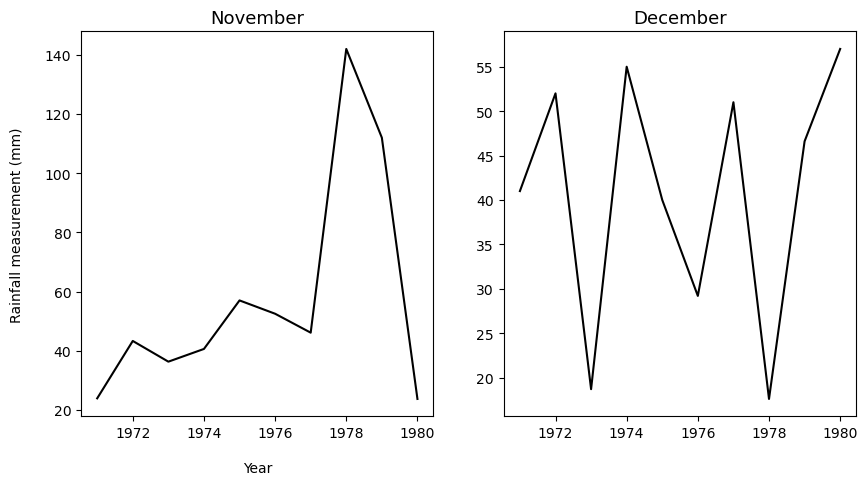

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

ax[0].plot(rain["year"], rain["november"], color="black")
ax[1].plot(rain["year"], rain["december"], color="black")

ax[0].set_xlabel("Year", labelpad=15)
ax[0].set_ylabel("Rainfall measurement (mm)", labelpad=15)

ax[0].set_title("November", size=13)
ax[1].set_title("December", size=13);

**Fit the Bayesian regression model**

In [140]:
with pm.Model() as rainfall_model:
        
    x = pm.MutableData('x', rain['november'].values)
    y = pm.MutableData('y', rain['december'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0)
    beta = pm.Normal('beta', mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    
    # Simple linear regression model (expected value)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x, beta))
    
    # Likelihood
    obs_y = pm.Normal('obs_y',
                      mu=mu,
                      sigma=sigma,
                      observed=y)
    
    # Posterior distribution
    trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


**Predict**

In [141]:
# Change the value of the input (november_c) to predict the output (december)
# (based on this new value of the input)

with rainfall_model:
    pm.set_data({'x': [50.0]})
    posterior_pred = pm.sample_posterior_predictive(trace)

Sampling: [obs_y]


In [142]:
posterior_pred['posterior_predictive']['obs_y'].mean().values

array(31.93163124)

- It seems that when the november rainfall measurement is 50, our Bayesian model predicts that the december rainfall measurement will be approximately 32.

In [143]:
# 95% prediction interval
posterior_pred['posterior_predictive']['obs_y'].quantile([0.025, 0.975]).values

array([-8.69729972, 70.10113896])

In [165]:
# 95% posterior interval for the expected value of the prediction
E_pred = np.mean(posterior_pred['posterior_predictive']['obs_y'], axis=0)
np.quantile(E_pred, [0.025, 0.975])

array([12.14297326, 51.04057651])

In [176]:
trace['posterior']['beta'].mean().values

array(0.16490258)

- A beta coefficient in a linear regression model represents the change in the dependent variable (in this case, December rainfall) associated with a one-unit increase in the independent variable (November rainfall).
- Therefore, for one unit increase (i.e. one millimeter increase) in the rainfall measurement of november, the rainfall measurement of december is expected to  increase by approximately 0.165 millimeters.

<br>

<br>

<h3 align="left">Task 4</h3>

Let us examine a simple linear regression model

$$ y_i = \alpha \, + \beta_i  x_i \, + \, \epsilon_i, \quad \epsilon_i \sim N(0, \sigma^2), \quad i=1,...,n. $$

Assume we have a response variable "exam scores" that can take values in the range of 0 to 24, and an explanatory variable "demo points" that can take values in the range of 0 to 6. Consider what kind of prior distributions you would set for the model parameters α, β, and σ in this case. Justify your choices in words and by simulating observations from the predictive prior distribution when x = 3.

Since the values of the parameters $\, \alpha \,$ and $\, \beta \,$ can take only take values from a specified range, one can use the uniform distribution for the priors of $\, \alpha \,$ and $\, \beta.$ Since it is not explicitly specified, I am assuming that exam scores and demo points are continuous variables and therefore I am going to use the [continuous uniform](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Uniform.html) distribution of the PyMC library.

As for $\, \sigma, \,$ one can use the [HalfNormal](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.HalfNormal.html) distribution of the PyMC library, which essentially is the positive side of the normal distribution. The choice here becomes apparent since $\, \sigma \,$ is defined as the square root of variance, and therefore can't take negative values.

**Fit the Bayesian regression model**

In [327]:
with pm.Model() as model:
    
    # Explanatory variable value
    x = 3
    
    # Priors
    alpha = pm.Uniform('alpha', lower=0, upper=24)
    beta = pm.Uniform('beta', lower=0, upper=6)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Expected value
    mu = pm.Deterministic('mu', alpha + beta*x)
    
    # Likelihood
    exam_scores = pm.TruncatedNormal('exam_scores', 
                                     mu=mu, 
                                     sigma=sigma,
                                     lower=0,
                                     upper=24)

- Note that TruncatedNormal distribution samples from a normal distribution but truncates the samples to fall within a specified range (lower, upper).

$\quad \quad \boldsymbol{\rightarrow} \,$ Any samples that fall outside the specified range are rejected and resampled until they fall within the range.

In [328]:
# Sample from the prior distribution

with model:
    prior_obs = pm.sample_prior_predictive(samples=2000)

Sampling: [alpha, beta, exam_scores, sigma]


In [329]:
prior_predictive = prior_obs['prior']['exam_scores'].values.flatten()

**Visualize the prior predictive distribution**

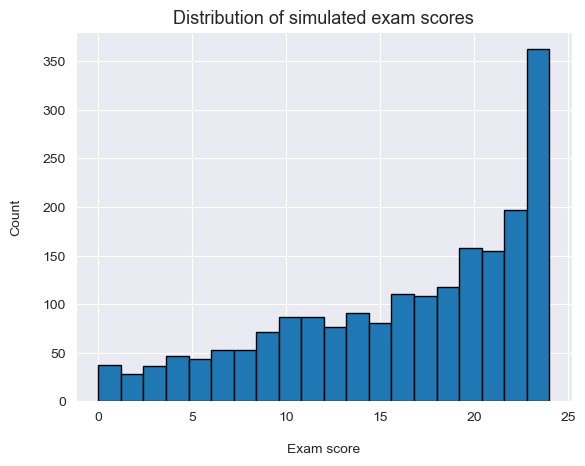

In [330]:
plt.hist(prior_predictive, bins=20, edgecolor='black');
plt.xlabel('Exam score', labelpad=15)
plt.ylabel('Count', labelpad=15)
plt.title('Distribution of simulated exam scores', size=13);

<br>

<br>

<h3 align="left">Task 5</h3>

Let's say that we have gathered the following data:

| **Demo points** | **Exam score** |
|-----------------:|------------:|
|              6.0 |          15 |
|              5.0 |          20 |
|              6.0 |          16 |
|              5.5 |          15 |
|              5.5 |          14 |
|              6.0 |          21 |
|              6.0 |          24 |
|              6.0 |          17 |
|              0.0 |           7 |
|              6.0 |          17 |
|              3.0 |          13 |
|              5.0 |          19 |
|              4.0 |          14 |
|              6.0 |          19 |
|              4.0 |          11 |
|              5.0 |           8 |
|              5.5 |          11 |
|              5.5 |          14 |
|              2.5 |          12 |
|              4.0 |           6 |
|              0.0 |           5 |
|              6.0 |          20 |
|              0.0 |           4 |



Fit the model described in the previous task (5) to the dataset, where the response variable is the exam score and the predictor variable is demo points, using the prior distributions chosen in the previous task (5). Interpret the results.

In [292]:
data = {'demo_points': [6,5,6,5.5,5.5,6,6,6,0,6,3,5,4,6,4,5,5.5,5.5,2.5,4,0,6,0],
        'exam_score': [15,20,16,15,14,21,24,17,7,17,13,19,14,19,11,8,11,14,12,6,5,20,4]}
        
df = pd.DataFrame(data)
df.head()

,demo_points,exam_score
0,6.0,15
1,5.0,20
2,6.0,16
3,5.5,15
4,5.5,14


**Visualize**

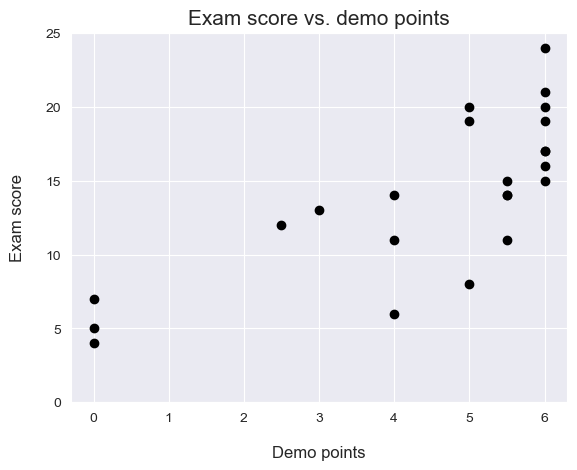

In [313]:
plt.figure(dpi=100)
sns.set_style('darkgrid')
plt.scatter(df['demo_points'], df['exam_score'], color='black');
plt.ylim(0, 25)
plt.xlabel('Demo points', size=12, labelpad=15)
plt.ylabel('Exam score', size=12, labelpad=15)
plt.title('Exam score vs. demo points', size=15);

**Fit the Bayesian regression model**

In [331]:
demo_points = df['demo_points'].values
exam_score = df['exam_score'].values

In [350]:
with pm.Model() as exam_model:
    
    # Priors
    alpha = pm.Uniform('alpha', lower=0, upper=24)
    beta = pm.Uniform('beta', lower=0, upper=6)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    mu = pm.Deterministic('mu', alpha + demo_points*beta)
    
    # Likelihood
    exam_scores = pm.TruncatedNormal('exam_scores', 
                                     mu=mu, 
                                     sigma=sigma,
                                     lower=0,
                                     upper=24)
    
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      cores=4,
                      compute_convergence_checks='none',
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, exam_scores]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.


In [351]:
# Intercept coefficient
trace['posterior']['alpha'].mean().values

array(12.02149158)

- When a person has zero demo points, their expected exam score is approximately 12.02.

In [352]:
# Regression coefficient for demo_points
trace['posterior']['beta'].mean().values

array(3.05357774)

- One unit increase in the explanatory variable (i.e. one more demo point) is associated with an increase of approximately 3 exam points.